# Draft of H3 evaluation
grid-cell wise comparison of metrics
* `base`: the ground truth (manually simplified)
* `comp`: the method to compare (for now, as example: the parenx/voronoi simplification)

In [1]:
%load_ext watermark
%watermark

Last updated: 2024-12-02T15:51:26.002258+01:00

Python implementation: CPython
Python version       : 3.11.9
IPython version      : 8.26.0

Compiler    : Clang 16.0.6 
OS          : Darwin
Release     : 23.6.0
Machine     : x86_64
Processor   : i386
CPU cores   : 12
Architecture: 64bit



In [12]:
import os
import pathlib

import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import momepy as mm
import numpy as np

from core import stats, utils, viz

%watermark -w
%watermark -iv

Watermark: 2.4.3

momepy    : 0.8.1
core      : 0.1.dev112+g68a4526
numpy     : 1.26.4
matplotlib: 3.9.2



make directories for evaluation results

In [3]:
evalfolder = "../../evaluation/"
os.makedirs(evalfolder, exist_ok=True)
subfolders = [evalfolder + str(fua) for fua in utils.fua_city]
for sub in subfolders:
    os.makedirs(sub, exist_ok=True)

Choose use case (FUA)

In [4]:
# which FUA?
fua = 869

# which h3 resolution?
res = 9

meta = utils.read_sample_data()
geom = meta.loc[meta.eFUA_ID == fua, "geometry"]
city = meta.loc[meta.eFUA_ID == fua, "eFUA_name"].values[0]

gdf_orig = utils.read_original(fua)
proj_crs = gdf_orig.crs

Make grid

In [5]:
base_grid = utils.make_grid(fua, res, proj_crs)

Read in results from different methods

In [ ]:
# def func(m):
#     match m:
#         case "orig":
#             gdf = utils.read_original


def read_method_outputs(method, proj_crs=None):
    if method == "orig":
        gdf = utils.read_original(fua)
    elif method == "manual":
        gdf = utils.read_manual(fua, proj_crs)
    elif method == "osmnx":
        gdf = utils.read_osmnx(fua, proj_crs)
    elif method == "parenx-voronoi":
        gdf = utils.read_parenx(fua, proj_crs, "voronoi")
    elif method == "parenx-skeletonize":
        gdf = utils.read_parenx(fua, proj_crs, "skeletonize")
    elif method == "sgeop":
        gdf = utils.read_sgeop(fua, proj_crs)
    else:
        raise ValueError("Not implemented")
    return gdf


# read results from all methods into dict

methods_to_evaluate = [
    "orig",
    "manual",
    "osmnx",
    "parenx-voronoi",
    "parenx-skeletonize",
    "sgeop",
]

methods = {}

for method in methods_to_evaluate:
    print(f"Reading in results for {method}")
    gdf = read_method_outputs(method, proj_crs)
    G = mm.gdf_to_nx(gdf, length="length", integer_labels=True)
    nodes, edges = mm.nx_to_gdf(G)
    nodes = stats.add_node_degree(nodes, G)

    methods[method] = {}
    methods[method]["gdf"] = gdf
    methods[method]["graph"] = G
    methods[method]["nodes"] = nodes
    methods[method]["edges"] = edges

    ### grid with stats eval for this method only
    grid = base_grid.copy()

    # add ratio columns to grid
    grid[["edge_count", "edge_length"]] = grid.apply(
        lambda x: stats.get_edge_stats(edges, x.geometry),  # noqa: B023
        axis=1,
        result_type="expand",
    )
    grid[["node_count", "node_degrees", "avg_degree"]] = grid.apply(
        lambda x: stats.get_node_stats(nodes, x.geometry),  # noqa: B023
        axis=1,
        result_type="expand",
    )

    # save grid to dict
    methods[method]["grid"] = grid

Reading in results for orig
Reading in results for manual
Reading in results for osmnx
Reading in results for parenx-voronoi
Reading in results for parenx-skeletonize
Reading in results for sgeop


In [ ]:
evaldict = {}

methodpairs_to_compare = [
    ("manual", "orig"),
    ("manual", "osmnx"),
    ("manual", "parenx-voronoi"),
    ("manual", "parenx-skeletonize"),
    ("manual", "sgeop"),
]

for m1, m2 in methodpairs_to_compare:
    # make sure both methods are read into dict
    assert m1 in methods, f"Need to read in {m1} results first!"
    assert m2 in methods, f"Need to read in {m2} results first!"

    # get base grid
    grid = base_grid.copy()

    # add ratio columns
    for var in ["edge_count", "edge_length", "node_count", "avg_degree"]:
        grid[f"{var}_ratio"] = methods[m1]["grid"][var] / methods[m2]["grid"][var]

    # save grid as dict entry
    evaldict[f"{m1}_{m2}"] = grid

    del grid

# Usage of evaldict

In evaldict, evaluation results are stored.

key: pair of methods (left, right); 

value: grid with `_ratio` columns for evaluation variables (left / right)

In [ ]:
evaldict["orig_manual"]

In [ ]:
evaldict["manual_orig"]

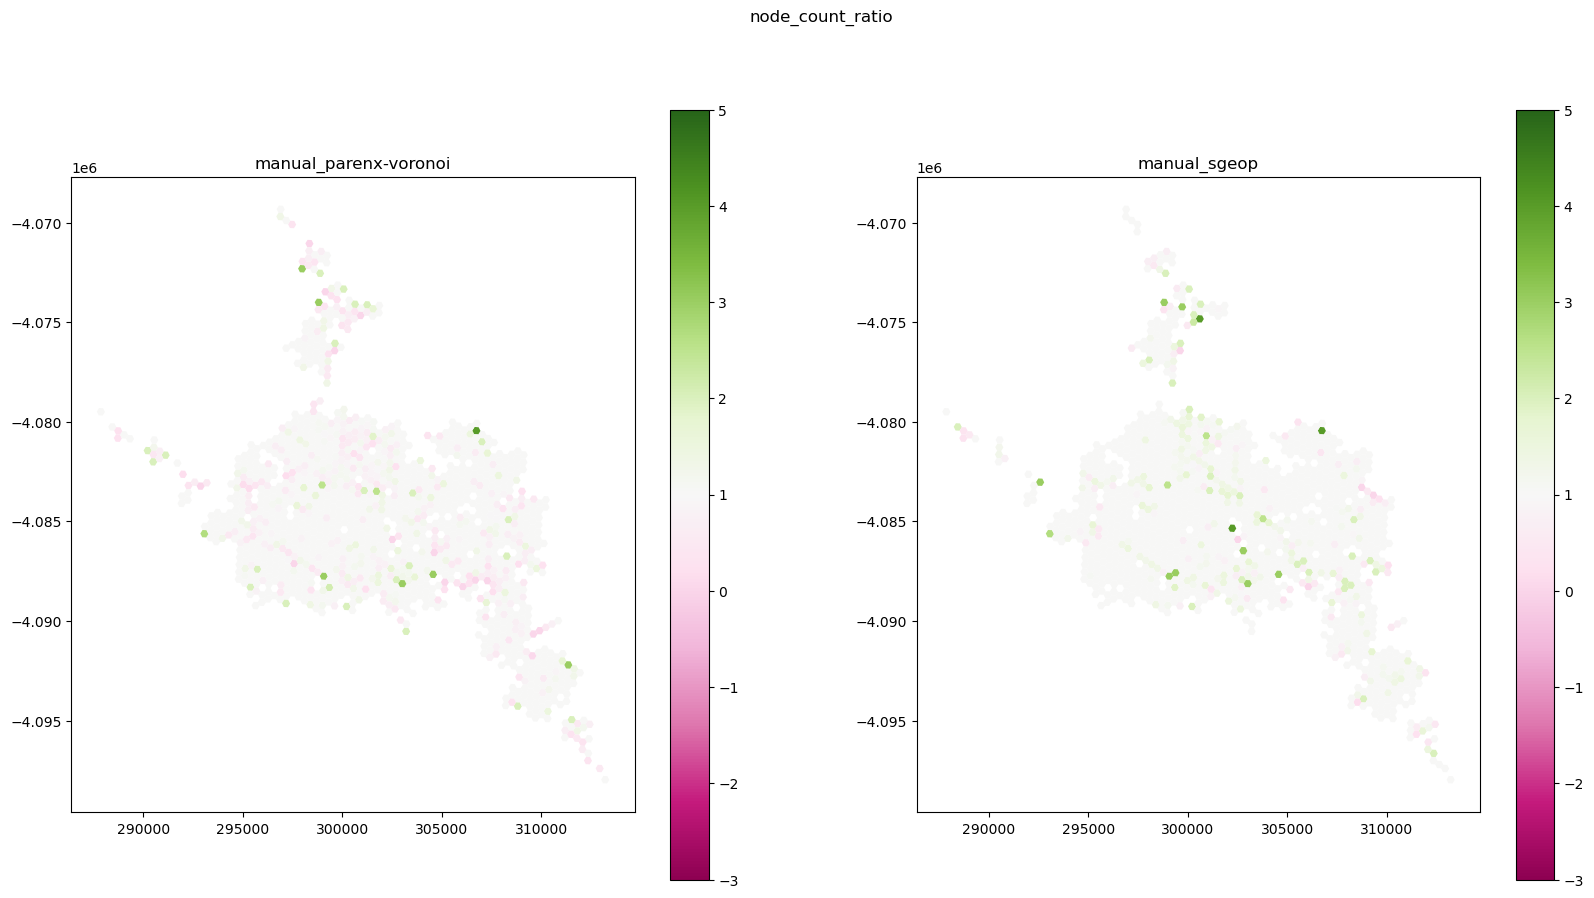

In [29]:
comp1 = "manual_parenx-voronoi"
comp2 = "manual_sgeop"
var = "node_count_ratio"

cmap = cm.PiYG

fig, ax = plt.subplots(1, 2, figsize=(20, 10))

i = 0
evaldict[comp1].plot(
    ax=ax[i],
    column=var,
    # norm=colors.CenteredNorm(vcenter=1),
    vmin=-3,
    vmax=5,
    cmap=cmap,
    legend=True,
)
ax[i].set_title(comp1)

i = 1
evaldict[comp2].plot(
    ax=ax[i],
    column=var,
    # norm=colors.CenteredNorm(vcenter=1),
    vmin=-3,
    vmax=5,
    cmap=cmap,
    legend=True,
)
ax[i].set_title(comp2)

plt.suptitle(var);

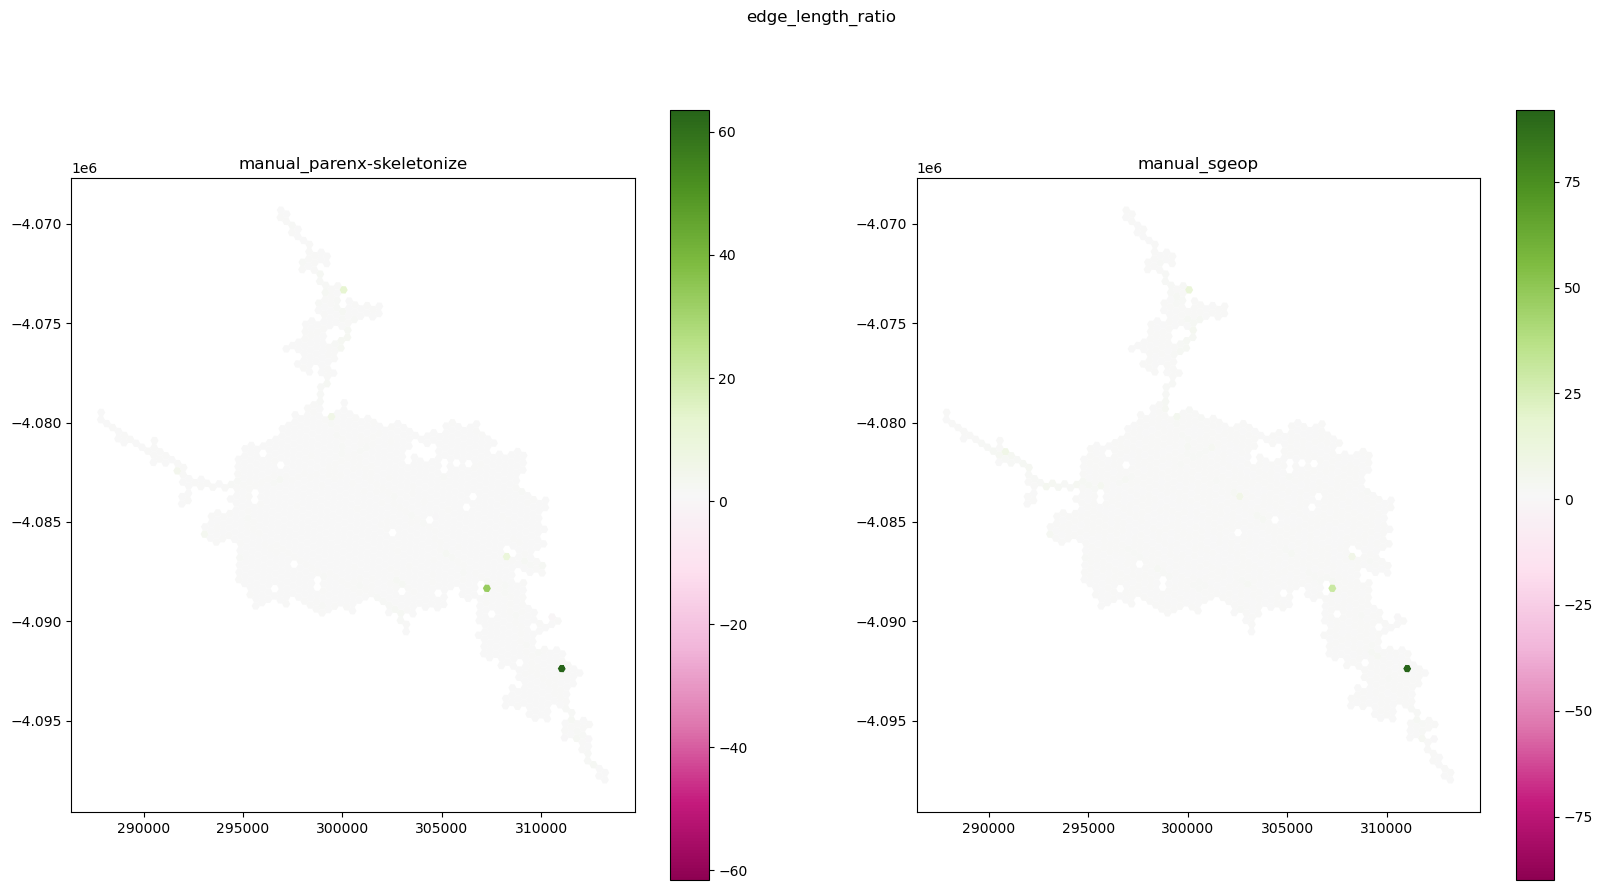

In [26]:
comp1 = "manual_parenx-skeletonize"
comp2 = "manual_sgeop"
var = "edge_length_ratio"

cmap = cm.PiYG

fig, ax = plt.subplots(1, 2, figsize=(20, 10))

i = 0
evaldict[comp1].plot(
    ax=ax[i],
    column=var,
    norm=colors.CenteredNorm(vcenter=1),
    cmap=cmap,
    legend=True,
)
ax[i].set_title(comp1)

i = 1
evaldict[comp2].plot(
    ax=ax[i],
    column=var,
    norm=colors.CenteredNorm(vcenter=1),
    cmap=cmap,
    legend=True,
)
ax[i].set_title(comp2)

plt.suptitle(var);